In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
import joblib


In [3]:
path = "/content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/Liver.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
df.head()


Shape: (583, 11)


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB
None

Missing values per column:
 Age                           0
Gender                   

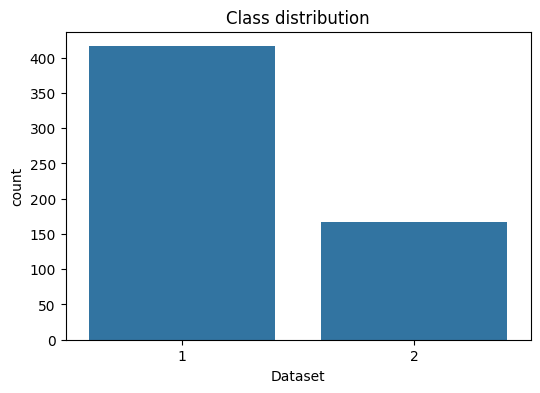

In [4]:
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nTarget distribution (Dataset):\n", df['Dataset'].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(x='Dataset', data=df)
plt.title('Class distribution')
plt.show()


In [5]:
df = df.dropna()

df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

X = df.drop('Dataset', axis=1)
y = df['Dataset'].apply(lambda x: 1 if x==1 else 0)

print("After cleaning shape:", X.shape)


After cleaning shape: (579, 10)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (463, 10) Test shape: (116, 10)


In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42)
}


In [8]:
cv_folds = 3
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
scoring = ['accuracy','precision','recall','f1','roc_auc']

results = []
for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    results.append({
        'Model': name,
        'Accuracy': np.mean(cv_res['test_accuracy']),
        'Precision': np.mean(cv_res['test_precision']),
        'Recall': np.mean(cv_res['test_recall']),
        'F1': np.mean(cv_res['test_f1']),
        'ROC-AUC': np.mean(cv_res['test_roc_auc'])
    })

results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
results_df


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
3,SVM,0.712736,0.715218,0.993939,0.831848,0.612325
0,Logistic Regression,0.727789,0.744243,0.942452,0.831327,0.734803
2,Random Forest,0.712736,0.755217,0.885176,0.814306,0.726564
1,Decision Tree,0.637285,0.766518,0.713186,0.735363,0.651668


In [9]:
print(results_df.to_string(index=False))
top3_names = results_df['Model'].tolist()[:3]
print("\nTop 3 models (by F1):", top3_names)


              Model  Accuracy  Precision   Recall       F1  ROC-AUC
                SVM  0.712736   0.715218 0.993939 0.831848 0.612325
Logistic Regression  0.727789   0.744243 0.942452 0.831327 0.734803
      Random Forest  0.712736   0.755217 0.885176 0.814306 0.726564
      Decision Tree  0.637285   0.766518 0.713186 0.735363 0.651668

Top 3 models (by F1): ['SVM', 'Logistic Regression', 'Random Forest']


In [10]:
# -*- coding: utf-8 -*-
import os
import time
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# --- 1. Load Dataset ---

print("Initial shape:", df.shape)
print(df.head())
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nTarget distribution:\n", df['Dataset'].value_counts(normalize=True))

# Drop rows with missing values (or handle differently if you want)
df = df.dropna()
print("After dropping missing values:", df.shape)

# --- 2. Preprocessing ---
target_column = 'Dataset'
categorical_columns = ['Gender']  # adjust as needed, empty list if none

# Label encode target to binary 0/1 if not already
df[target_column] = df[target_column].apply(lambda x: 1 if x == 1 else 0)

# Label encode categorical features
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Split features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Fill missing numeric features with mean (should be none after dropna, but just in case)
X = X.fillna(X.mean())

# --- 3. Normalization ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. Feature Selection using PCA ---
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- 5. Dataset Splitting ---
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# --- 6. Model Training ---
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

SAVE_DIR = "models_pickle"
os.makedirs(SAVE_DIR, exist_ok=True)

results = []

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    conf_matrix = confusion_matrix(y_test, y_pred)

    cv_scores = cross_val_score(model, X_pca, y, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()

    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1: {f1:.4f}, ROC-AUC: {roc_auc if roc_auc else 'N/A'}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"CV Accuracy: {cv_mean:.4f}")
    print(f"Training Time: {train_time:.2f} sec\n")

    # Save model
    with open(os.path.join(SAVE_DIR, f"{name}_model.pkl"), 'wb') as f:
        pickle.dump(model, f)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC_AUC': roc_auc,
        'CV_Accuracy': cv_mean,
        'Training_Time_sec': train_time
    })

# Save scaler and PCA for later preprocessing
with open(os.path.join(SAVE_DIR, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)
with open(os.path.join(SAVE_DIR, "pca.pkl"), "wb") as f:
    pickle.dump(pca, f)

print("All models and preprocessing artifacts saved.")

# --- 7. Prediction Function ---
def load_artifacts(model_name):
    with open(os.path.join(SAVE_DIR, f"{model_name}_model.pkl"), "rb") as f:
        model = pickle.load(f)
    with open(os.path.join(SAVE_DIR, "scaler.pkl"), "rb") as f:
        scaler = pickle.load(f)
    with open(os.path.join(SAVE_DIR, "pca.pkl"), "rb") as f:
        pca = pickle.load(f)
    return model, scaler, pca

def predict_disease(user_input: dict, model_name: str):
    """
    user_input: dict of feature:value pairs, keys must match original features before PCA
    model_name: string, one of trained models ("XGBoost", "SVM", etc.)
    """
    model, scaler, pca = load_artifacts(model_name)

    input_df = pd.DataFrame([user_input])

    # Make sure input has all required features; fill missing with mean or 0
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0  # or you can use X[col].mean()

    input_df = input_df[X.columns]  # reorder columns to match training

    # Preprocess input: scale, then PCA transform
    input_scaled = scaler.transform(input_df)
    input_pca = pca.transform(input_scaled)

    pred = model.predict(input_pca)[0]
    confidence = None
    if hasattr(model, "predict_proba"):
        confidence = model.predict_proba(input_pca)[0][1]

    return pred, confidence


# --- Example usage ---
if __name__ == "__main__":
    example_input = {
        'Age': 55,
        'Gender': 1,
        'Total_Bilirubin': 0.9,
        'Direct_Bilirubin': 0.2,
        'Alkaline_Phosphotase': 200,
        'Alamine_Aminotransferase': 40,
        'Aspartate_Aminotransferase': 30,
        'Total_Proteins': 6.8,
        'Albumin': 3.5,
        'Albumin_and_Globulin_Ratio': 1.0
    }

    prediction, confidence = predict_disease(example_input, model_name="XGBoost")
    print(f"Prediction: {'Positive (1)' if prediction == 1 else 'Negative (0)'}")
    if confidence is not None:
        print(f"Confidence: {confidence:.2f}")


Initial shape: (579, 11)
   Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65       0              0.7               0.1                   187   
1   62       1             10.9               5.5                   699   
2   62       1              7.3               4.1                   490   
3   58       1              1.0               0.4                   182   
4   72       1              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   Albumin  Albumin_and_Globulin_Ratio  Dataset  
0      3.3             

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:03:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:03:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:03:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:03:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:03:26] WARNING: /w

XGBoost - Accuracy: 0.7414, Precision: 0.7677, Recall: 0.9157, F1: 0.8352, ROC-AUC: 0.7294633077765608
Confusion Matrix:
[[10 23]
 [ 7 76]]
CV Accuracy: 0.6806
Training Time: 0.16 sec

Training SVM...
SVM - Accuracy: 0.7155, Precision: 0.7155, Recall: 1.0000, F1: 0.8342, ROC-AUC: 0.6644760861628333
Confusion Matrix:
[[ 0 33]
 [ 0 83]]
CV Accuracy: 0.7116
Training Time: 0.04 sec

Training RandomForest...
RandomForest - Accuracy: 0.7241, Precision: 0.7476, Recall: 0.9277, F1: 0.8280, ROC-AUC: 0.6933187294633079
Confusion Matrix:
[[ 7 26]
 [ 6 77]]
CV Accuracy: 0.6685
Training Time: 0.38 sec

Training DecisionTree...
DecisionTree - Accuracy: 0.5690, Precision: 0.6813, Recall: 0.7470, F1: 0.7126, ROC-AUC: 0.4341000365096751
Confusion Matrix:
[[ 4 29]
 [21 62]]
CV Accuracy: 0.6374
Training Time: 0.01 sec

Training KNN...
KNN - Accuracy: 0.6810, Precision: 0.7500, Recall: 0.8313, F1: 0.7886, ROC-AUC: 0.6221248630887185
Confusion Matrix:
[[10 23]
 [14 69]]
CV Accuracy: 0.6374
Training Time: 0

In [11]:
# -*- coding: utf-8 -*-
import os
import time
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# --- 1. Load Dataset ---
# Make sure you load your df here before print statements, e.g.:
# df = pd.read_csv('your_liver_dataset.csv')

print("Initial shape:", df.shape)
print(df.head())
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nTarget distribution:\n", df['Dataset'].value_counts(normalize=True))

# Drop rows with missing values
df = df.dropna()
print("After dropping missing values:", df.shape)

# --- 2. Preprocessing ---
target_column = 'Dataset'
categorical_columns = ['Gender']  # adjust as needed

# Binary encode target
df[target_column] = df[target_column].apply(lambda x: 1 if x == 1 else 0)

# Encode categorical features
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

X = df.drop(columns=[target_column])
y = df[target_column]

X = X.fillna(X.mean())

# --- 3. Normalization ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. PCA ---
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- 5. Split Dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# --- 6. Model Training ---
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

SAVE_DIR = "/content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/liver_models"
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Models and preprocessors will be saved in: {SAVE_DIR}")

results = []

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    conf_matrix = confusion_matrix(y_test, y_pred)

    cv_scores = cross_val_score(model, X_pca, y, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()

    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1: {f1:.4f}, ROC-AUC: {roc_auc if roc_auc else 'N/A'}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"CV Accuracy: {cv_mean:.4f}")
    print(f"Training Time: {train_time:.2f} sec\n")

    model_file = os.path.join(SAVE_DIR, f"{name}_model.pkl")
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved {name} model to {model_file}")

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC_AUC': roc_auc,
        'CV_Accuracy': cv_mean,
        'Training_Time_sec': train_time
    })

# Save scaler and PCA
scaler_file = os.path.join(SAVE_DIR, "scaler.pkl")
with open(scaler_file, "wb") as f:
    pickle.dump(scaler, f)
print(f"Saved scaler to {scaler_file}")

pca_file = os.path.join(SAVE_DIR, "pca.pkl")
with open(pca_file, "wb") as f:
    pickle.dump(pca, f)
print(f"Saved PCA to {pca_file}")

print("All models and preprocessing artifacts saved successfully.")

# --- 7. Prediction Function ---
def load_artifacts(model_name):
    with open(os.path.join(SAVE_DIR, f"{model_name}_model.pkl"), "rb") as f:
        model = pickle.load(f)
    with open(os.path.join(SAVE_DIR, "scaler.pkl"), "rb") as f:
        scaler = pickle.load(f)
    with open(os.path.join(SAVE_DIR, "pca.pkl"), "rb") as f:
        pca = pickle.load(f)
    return model, scaler, pca

def predict_disease(user_input: dict, model_name: str):
    model, scaler, pca = load_artifacts(model_name)

    input_df = pd.DataFrame([user_input])

    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0

    input_df = input_df[X.columns]

    input_scaled = scaler.transform(input_df)
    input_pca = pca.transform(input_scaled)

    pred = model.predict(input_pca)[0]
    confidence = None
    if hasattr(model, "predict_proba"):
        confidence = model.predict_proba(input_pca)[0][1]

    return pred, confidence

# --- Example usage ---
if __name__ == "__main__":
    example_input = {
        'Age': 55,
        'Gender': 1,
        'Total_Bilirubin': 0.9,
        'Direct_Bilirubin': 0.2,
        'Alkaline_Phosphotase': 200,
        'Alamine_Aminotransferase': 40,
        'Aspartate_Aminotransferase': 30,
        'Total_Proteins': 6.8,
        'Albumin': 3.5,
        'Albumin_and_Globulin_Ratio': 1.0
    }

    prediction, confidence = predict_disease(example_input, model_name="XGBoost")
    print(f"Prediction: {'Positive (1)' if prediction == 1 else 'Negative (0)'}")
    if confidence is not None:
        print(f"Confidence: {confidence:.2f}")


Initial shape: (579, 11)
   Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65       0              0.7               0.1                   187   
1   62       1             10.9               5.5                   699   
2   62       1              7.3               4.1                   490   
3   58       1              1.0               0.4                   182   
4   72       1              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   Albumin  Albumin_and_Globulin_Ratio  Dataset  
0      3.3             

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:03:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:03:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:03:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:03:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:03:32] WARNING: /w

XGBoost - Accuracy: 0.7414, Precision: 0.7677, Recall: 0.9157, F1: 0.8352, ROC-AUC: 0.7294633077765608
Confusion Matrix:
[[10 23]
 [ 7 76]]
CV Accuracy: 0.6806
Training Time: 0.22 sec

Saved XGBoost model to /content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/liver_models/XGBoost_model.pkl
Training SVM...
SVM - Accuracy: 0.7155, Precision: 0.7155, Recall: 1.0000, F1: 0.8342, ROC-AUC: 0.6644760861628333
Confusion Matrix:
[[ 0 33]
 [ 0 83]]
CV Accuracy: 0.7116
Training Time: 0.09 sec

Saved SVM model to /content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/liver_models/SVM_model.pkl
Training RandomForest...
RandomForest - Accuracy: 0.7241, Precision: 0.7476, Recall: 0.9277, F1: 0.8280, ROC-AUC: 0.6933187294633079
Confusion Matrix:
[[ 7 26]
 [ 6 77]]
CV Accuracy: 0.6685
Training Time: 0.61 sec

Saved RandomForest model to /content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/liver_models/RandomForest_model.